### Perform explanation based on model PC replacement

In [68]:
# 3rd party
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
from pathlib import Path
import json

# local
from archived_experiments.explainability.post_processing.utils_postprocessing import top_n, threshold, post_process_flags

In [ ]:
# Load the arguments
with open('/Users/msaragoc/Library/CloudStorage/OneDrive-NASA/Projects/exoplanet_transit_classification/experiments/explainability/model_pc_replacement/arguments_postprocessing.json', 'r') as fid:
    arguments = json.load(fid)

# experiment directory
exp_root_dir = Path(arguments['exp_dir_fp'])

In [69]:
# exp_root_dir = Path('/Users/msaragoc/Library/CloudStorage/OneDrive-NASA/Projects/exoplanet_transit_classification/experiments/explainability/model_pc_replacement/run_num_model_pcs_15_05-02-2023_1748')

n_trials = len([fp for fp in exp_root_dir.iterdir() if fp.is_dir() and 'trial_' in fp.name])  # number of trials conducted for the experiment
n_pcs = int(exp_root_dir.name.split('_')[4])  # number of model PCs used in the experiment
eval_metric = 'min'  # metric used to aggregate explanation scores across model PCs (max, median, or min)
save_dir = exp_root_dir / f'{eval_metric}_eval'
save_dir.mkdir(exist_ok=True)
get_max = True  # get max top-n
branch_idxs_to_keep = [1, 2, 3, 4, 6, 7]  # do not keep global flux and stellar flags
robo_cols = ['Global Flux Flag', 'Local Flux Flag', 'Centroid Flag', 'Odd Even Flag', 'Secondary Flag', 'Stellar Flag', 'DV Flag', 'No Flag']
score_cols = [
    'global flux',
    'local_flux',
    'global_and_local_centroid',
    'odd_even',
    'secondary',
    'stellar',
    'DV',
]

tce_tbl = pd.read_csv('/Users/msaragoc/Library/CloudStorage/OneDrive-NASA/Projects/exoplanet_transit_classification/data/ephemeris_tables/kepler/q1-q17_dr25/11-17-2021_1243/q1_q17_dr25_tce_3-6-2023_1734.csv')

In [70]:
# Read Robovetter Minor Flags
robo_flags = pd.read_csv('/Users/msaragoc/Library/CloudStorage/OneDrive-NASA/Projects/exoplanet_transit_classification/interns/kaylie_explainability/kdd/robovetter_flags_all_DR25.csv')

In [71]:
robo_flags.head()
# adding no flag column for TCEs with no FP flags set to one
robo_flags['No Flag'] = 0
# robo_flags.loc[(robo_flags[robo_cols[:-1]] == 0).all(axis=1), 'No Flag'] = 1
tce_tbl = pd.read_csv('/Users/msaragoc/Library/CloudStorage/OneDrive-NASA/Projects/exoplanet_transit_classification/data/ephemeris_tables/kepler/q1-q17_dr25/11-17-2021_1243/q1_q17_dr25_tce_3-6-2023_1734.csv')
robo_flags['uid'] = robo_flags[['target_id', 'tce_plnt_num']].apply(lambda x: f'{x[0]}-{x[1]}', axis=1)
robo_flags['uid'].value_counts()
robo_flags = robo_flags.merge(tce_tbl[['uid', 'label']], on=['uid'], how='left', validate='one_to_one')
robo_flags.loc[robo_flags['label'] == 'PC', 'No Flag'] = 1

In [72]:
robo_array = robo_flags[robo_cols].to_numpy()
# robo = robo_array[:, branch_idxs_to_keep]
robo = np.array(robo_array[:, :-1])
robo_noflag = np.array(robo_array[:, -1])

### Aggregate explanation scores across model PCs and trials

In [46]:
# data sets for which to compute final explanation scores
datasets = [
    # 'train',
    # 'val',
    'test'
]

info_cols = [
    'target_id',
    'tce_plnt_num',
    'tce_period',
    'tce_duration',
    'original_label',
    'label',
]

for dataset in datasets:
    all_trials_scores = []
    for trial_i in range(n_trials):
        (save_dir / f'exp_{n_pcs}_PCs_trial_{trial_i}').mkdir(exist_ok=True)
        all_pcs_scores = []
        for pc_i in range(n_pcs):  # get explanation scores for all model PCs in a given trial

            pc_scores = pd.read_csv(exp_root_dir / f'exp_{n_pcs}_PCs_trial_{trial_i}' / f'{dataset}_top_{pc_i}.csv')

            # # exclude non-KOIs
            # pc_scores = pd.merge(pc_scores, tce_tbl[['target_id', 'tce_plnt_num', 'kepoi_name']], on=['target_id', 'tce_plnt_num'], validate='one_to_one', how='left')
            # pc_scores = pc_scores.loc[~pc_scores['kepoi_name'].isna()].reset_index()

            if trial_i == 0:
                info_cols_tbl = pc_scores[[col for col in info_cols]]

            # pc_scores = 2 * (-1 * pc_scores[score_cols].to_numpy() - 0.5)
            pc_scores = -1 * pc_scores[score_cols].to_numpy()

            all_pcs_scores.append(pc_scores)

        # aggregate explanation scores across model PCs
        if eval_metric == 'min':
            agg_pcs_scores = np.min(all_pcs_scores, axis=0)
        elif eval_metric == 'max':
            agg_pcs_scores = np.max(all_pcs_scores, axis=0)
        elif eval_metric == 'mean':
            agg_pcs_scores = np.mean(all_pcs_scores, axis=0)
        elif eval_metric == 'median':
            agg_pcs_scores = np.median(all_pcs_scores, axis=0)
        else:
            raise ValueError(f'The metric {eval_metric} was not implemented.')

        all_pcs_scores_tbl = pd.concat([info_cols_tbl, pd.DataFrame(agg_pcs_scores, columns=score_cols)], axis=1)
        all_pcs_scores_tbl.to_csv(save_dir / f'exp_{n_pcs}_PCs_trial_{trial_i}' / f'{dataset}_scores.csv', index=False)
        all_trials_scores.append(all_pcs_scores_tbl[score_cols].to_numpy())

    # aggregate explanation scores across trials
    all_trials_scores_mean = np.mean(all_trials_scores, axis=0)
    all_trials_scores_std = np.std(all_trials_scores, axis=0, ddof=1)
    all_trials_scores_mean_tbl = pd.concat([info_cols_tbl, pd.DataFrame(all_trials_scores_mean, columns=score_cols)], axis=1)
    all_trials_scores_std_tbl = pd.concat([info_cols_tbl, pd.DataFrame(all_trials_scores_std, columns=score_cols)], axis=1)
    all_trials_scores_mean_tbl.to_csv(save_dir / f'{dataset}_mean_scores.csv', index=False)
    all_trials_scores_std_tbl.to_csv(save_dir / f'{dataset}_std_scores.csv', index=False)

### Compute top-n metrics for FP flags

In [47]:
top_n_arr = np.arange(1,6)  # top-n values
dataset = 'test'

# metrics to be computed for each top-n
metrics_dict = {
    'precision_micro': {'average': 'micro', 'zero_division': 1},
    'precision_macro': {'average': 'macro', 'zero_division': 1},
    'precision_weighted': {'average': 'weighted', 'zero_division': 1},
    'precision_samples': {'average': 'samples', 'zero_division': 1},

    'recall_micro': {'average': 'micro', 'zero_division': 1},
    'recall_macro': {'average': 'macro', 'zero_division': 1},
    'recall_weighted': {'average': 'weighted', 'zero_division': 1},
    'recall_samples': {'average': 'samples', 'zero_division': 1},

    'hamming': {'sample_weight': None},
    'exact_match_ratio': {'sample_weight': None},

    'jaccard_micro': {'average': 'micro', 'zero_division': 1},
    'jaccard_macro': {'average': 'macro', 'zero_division': 1},
    'jaccard_weighted': {'average': 'weighted', 'zero_division': 1},
    'jaccard_samples': {'average': 'samples', 'zero_division': 1},
}
metrics_res = {'top_n': top_n_arr}
metrics_res.update({f'{metric_i}': np.zeros((len(top_n_arr), n_trials), dtype='float') for metric_i in metrics_dict})
metrics_res.update({f'{metric_i}': np.zeros((len(top_n_arr), n_trials), dtype='float') for metric_i in metrics_dict})

for trial_i in range(n_trials):

    # read explanation scores
    dataset_scores = pd.read_csv(save_dir / f'exp_{n_pcs}_PCs_trial_{trial_i}' / f'{dataset}_scores.csv')
    # add ground truth
    dataset_scores = pd.merge(dataset_scores, robo_flags, on=['target_id', 'tce_plnt_num'], validate='one_to_one', how='left')

    # get columns with scores for each occlusion grouping
    branch_explanations_scores = np.array(dataset_scores[score_cols])
    cnt_all_zero_fpflags = (branch_explanations_scores <= 0).all(axis=1).sum()
    if cnt_all_zero_fpflags > 0:
        print(f'Trial {trial_i} has {cnt_all_zero_fpflags} examples with all non-positive FP flags.')
    # # get flags for each branch
    robo_array = np.array(dataset_scores[robo_cols])

    # # add no_flag column; set to one when all other flags have non-positive explanation scores
    # branch_explanations_scores[(branch_explanations_scores <= 0.5)] = 0
    # noflag_explanation = np.zeros((len(branch_explanations_scores), 1), dtype='float')
    # noflag_explanation[(branch_explanations_scores == 0).all(axis=1)] = 1
    # branch_explanations_scores = np.concatenate([branch_explanations_scores, noflag_explanation], axis=1)

    robo, branch_explanations_scores = post_process_flags(robo_array, branch_explanations_scores, get_max=get_max, branch_idxs_to_keep=branch_idxs_to_keep[:-1])

    for n_i, n in enumerate(top_n_arr):

        branch_explanations_topn = top_n(branch_explanations_scores, n, get_max)

        for metric_i, metrics_params in metrics_dict.items():

            if 'precision' in metric_i:
                metrics_res[metric_i][n_i][trial_i] = precision_score(robo, branch_explanations_topn, **metrics_params)
            elif 'recall' in metric_i:
                metrics_res[metric_i][n_i][trial_i] = recall_score(robo, branch_explanations_topn, **metrics_params)
            elif 'hamming' in metric_i:
                metrics_res[metric_i][n_i][trial_i] = 1 - hamming_loss(robo, branch_explanations_topn, **metrics_params)
            elif 'jaccard' in metric_i:
                metrics_res[metric_i][n_i][trial_i] = jaccard_score(robo, branch_explanations_topn, **metrics_params)
            elif 'exact_match_ratio' in metric_i:
                metrics_res[metric_i][n_i][trial_i] = accuracy_score(robo, branch_explanations_topn, **metrics_params)

np.save(save_dir / f'metrics_top_n_{top_n_arr[0]}-{top_n_arr[-1]}_trials_{dataset}set.npy', metrics_res)

agg_metrics_res = {'top_n': top_n_arr}
agg_metrics_res.update({f'{metric_i}_mean': np.zeros(len(top_n_arr), dtype='float') for metric_i in metrics_dict})
agg_metrics_res.update({f'{metric_i}_std': np.zeros(len(top_n_arr), dtype='float') for metric_i in metrics_dict})
for metric_i, metrics_params in metrics_dict.items():
    for n_i, n in enumerate(top_n_arr):
        agg_metrics_res[f'{metric_i}_mean'][n_i] = np.mean(metrics_res[metric_i][n_i, :])
        agg_metrics_res[f'{metric_i}_std'][n_i] = np.std(metrics_res[metric_i][n_i, :], ddof=1)

agg_metrics_res_df = pd.DataFrame(agg_metrics_res)
agg_metrics_res_df.head()
agg_metrics_res_df.to_csv(save_dir / f'metrics_top_n_{top_n_arr[0]}-{top_n_arr[-1]}_{dataset}set.csv', index=False)

Trial 6 has 1 examples with all non-positive FP flags.
Trial 7 has 1 examples with all non-positive FP flags.


# Compute metrics across FP flags for a set of threshold values

In [48]:
thr_arr = np.linspace(-1, 1, 21, endpoint=True)

# metrics to be computed for the given threshold
metrics_dict = {
    'precision_micro': {'average': 'micro', 'zero_division': 1},
    'precision_macro': {'average': 'macro', 'zero_division': 1},
    'precision_weighted': {'average': 'weighted', 'zero_division': 1},
    'precision_samples': {'average': 'samples', 'zero_division': 1},

    'recall_micro': {'average': 'micro', 'zero_division': 1},
    'recall_macro': {'average': 'macro', 'zero_division': 1},
    'recall_weighted': {'average': 'weighted', 'zero_division': 1},
    'recall_samples': {'average': 'samples', 'zero_division': 1},

    'hamming': {'sample_weight': None},
    'exact_match_ratio': {'sample_weight': None},

    'jaccard_micro': {'average': 'micro', 'zero_division': 1},
    'jaccard_macro': {'average': 'macro', 'zero_division': 1},
    'jaccard_weighted': {'average': 'weighted', 'zero_division': 1},
    'jaccard_samples': {'average': 'samples', 'zero_division': 1},
}

metrics_res = {'thr': thr_arr}
metrics_res.update({metric_i: np.nan * np.ones((len(thr_arr), n_trials)) for metric_i in metrics_dict})

for trial_i in range(n_trials):

    dataset_scores = pd.read_csv(save_dir / f'exp_{n_pcs}_PCs_trial_{trial_i}' / f'{dataset}_scores.csv')
    dataset_scores = pd.merge(dataset_scores, robo_flags, on=['target_id', 'tce_plnt_num'], validate='one_to_one', how='left')

    # get columns with scores for each occlusion grouping
    scores_array = np.array(dataset_scores[score_cols])
    # get flags for each branch
    robo_array = np.array(dataset_scores[robo_cols[:-1]])

    # scores_array = np.concatenate([scores_array, np.nan * np.zeros((len(scores_array), 1))], axis=1)
    robo, branch_explanations_trials = post_process_flags(robo_array, scores_array, get_max=get_max, branch_idxs_to_keep=branch_idxs_to_keep[:-1])
    # branch_explanations_trials = branch_explanations_trials[:, :-1]

    for thr_i, thr in enumerate(thr_arr):

        branch_explanations_thr = threshold(branch_explanations_trials, thr)  # 1 - threshold(branch_explanations_trials, thr)

        # # add no_flag column; set to one when all other flags have non-positive explanation scores
        # noflag_explanation = np.zeros((len(branch_explanations_thr), 1), dtype='float')
        # noflag_explanation[(branch_explanations_thr == 0).all(axis=1)] = 1
        # branch_explanations_thr = np.concatenate([branch_explanations_thr, noflag_explanation], axis=1)

        for metric_i, metrics_params in metrics_dict.items():

            if 'precision' in metric_i:
                metrics_res[metric_i][thr_i][trial_i] = precision_score(robo, branch_explanations_thr, **metrics_params)
            elif 'recall' in metric_i:
                metrics_res[metric_i][thr_i][trial_i] = recall_score(robo, branch_explanations_thr, **metrics_params)
            elif 'hamming' in metric_i:
                metrics_res[metric_i][thr_i][trial_i] = 1 - hamming_loss(robo, branch_explanations_thr, **metrics_params)
            elif 'jaccard' in metric_i:
                metrics_res[metric_i][thr_i][trial_i] = jaccard_score(robo, branch_explanations_thr, **metrics_params)
            elif 'exact_match_ratio' in metric_i:
                metrics_res[metric_i][thr_i][trial_i] = accuracy_score(robo, branch_explanations_thr, **metrics_params)

np.save(save_dir / f'metrics_thr_{thr_arr[0]}-{thr_arr[-1]}_trials.npy', metrics_res)

agg_metrics_res = {'thr': thr_arr}
agg_metrics_res.update({f'{metric_i}_mean': np.zeros(len(thr_arr), dtype='float') for metric_i in metrics_dict})
agg_metrics_res.update({f'{metric_i}_std': np.zeros(len(thr_arr), dtype='float') for metric_i in metrics_dict})
for metric_i, metrics_params in metrics_dict.items():
    for thr_i, thr in enumerate(thr_arr):
        agg_metrics_res[f'{metric_i}_mean'][thr_i] = np.mean(metrics_res[metric_i][thr_i, :])
        agg_metrics_res[f'{metric_i}_std'][thr_i] = np.std(metrics_res[metric_i][thr_i, :], ddof=1)

metrics_res_df = pd.DataFrame(agg_metrics_res)
metrics_res_df.head()
metrics_res_df.to_csv(save_dir / f'metrics_thr_{thr_arr[0]}-{thr_arr[-1]}.csv', index=False)

# Compute metrics for PC for a set of threshold values

In [49]:
thr_arr = np.linspace(-1, 1, 21, endpoint=True)

# metrics to be computed for the given threshold
metrics_dict = {
    'precision': {'zero_division': 1},
    'recall': {'zero_division': 1},
    'hamming': {'sample_weight': None},
    'exact_match_ratio': {'sample_weight': None},
    'jaccard': {'zero_division': 1},
}

metrics_res = {'thr': thr_arr}
metrics_res.update({metric_i: np.nan * np.ones((len(thr_arr), n_trials)) for metric_i in metrics_dict})

for trial_i in range(n_trials):

    dataset_scores = pd.read_csv(save_dir / f'exp_{n_pcs}_PCs_trial_{trial_i}' / f'{dataset}_scores.csv')
    dataset_scores = pd.merge(dataset_scores, robo_flags, on=['target_id', 'tce_plnt_num'], validate='one_to_one', how='left')

    # get columns with scores for each occlusion grouping
    scores_array = np.array(dataset_scores[score_cols])
    # get flags for each branch
    robo_noflag = np.array(dataset_scores[robo_cols[-1]])

    _ , branch_explanations_trials = post_process_flags(robo_array, scores_array, get_max=get_max, branch_idxs_to_keep=branch_idxs_to_keep[:-1])

    for thr_i, thr in enumerate(thr_arr):

        # add no_flag column; set to one when all other flags have non-positive explanation scores
        idxs_allfps_inactive = (branch_explanations_trials <= thr).all(axis=1)
        noflag_explanation = np.zeros((len(branch_explanations_trials), 1), dtype='float')
        noflag_explanation[idxs_allfps_inactive] = 1

        branch_explanations_thr = threshold(noflag_explanation, thr)

        for metric_i, metrics_params in metrics_dict.items():

            if 'precision' in metric_i:
                metrics_res[metric_i][thr_i] = precision_score(robo_noflag, branch_explanations_thr, **metrics_params)
            elif 'recall' in metric_i:
                metrics_res[metric_i][thr_i] = recall_score(robo_noflag, branch_explanations_thr, **metrics_params)
            elif 'hamming' in metric_i:
                metrics_res[metric_i][thr_i] = 1 - hamming_loss(robo_noflag, branch_explanations_thr, **metrics_params)
            elif 'jaccard' in metric_i:
                metrics_res[metric_i][thr_i] = jaccard_score(robo_noflag, branch_explanations_thr, **metrics_params)
            elif 'exact_match_ratio' in metric_i:
                metrics_res[metric_i][thr_i] = accuracy_score(robo_noflag, branch_explanations_thr, **metrics_params)


agg_metrics_res = {'thr': thr_arr}
agg_metrics_res.update({f'{metric_i}_mean': np.zeros(len(thr_arr), dtype='float') for metric_i in metrics_dict})
agg_metrics_res.update({f'{metric_i}_std': np.zeros(len(thr_arr), dtype='float') for metric_i in metrics_dict})
for metric_i, metrics_params in metrics_dict.items():
    for thr_i, thr in enumerate(thr_arr):
        agg_metrics_res[f'{metric_i}_mean'][thr_i] = np.mean(metrics_res[metric_i][thr_i, :])
        agg_metrics_res[f'{metric_i}_std'][thr_i] = np.std(metrics_res[metric_i][thr_i, :], ddof=1)

metrics_res_df = pd.DataFrame(agg_metrics_res)
metrics_res_df.head()
metrics_res_df.to_csv(save_dir / f'metrics_pc_thr_{thr_arr[0]}-{thr_arr[-1]}.csv', index=False)

### Compute top-n precision and recall values for each feature group

In [50]:
dataset = 'test'
top_n_arr = np.arange(1, 6)  # top-n values
flags = ['Flux Flag', 'Centroid Flag', 'Odd Even Flag', 'Secondary Flag', 'DV Flag']  # , 'No Flag']
# metrics to be computed for each top-n
metrics_res = {'top_n': top_n_arr}
for flag in flags:
    metrics_res[f'precision_{flag}'] = np.zeros((len(top_n_arr), n_trials))
    metrics_res[f'recall_{flag}'] = np.zeros((len(top_n_arr), n_trials))

for trial_i in range(n_trials):

    dataset_scores = pd.read_csv(save_dir / f'exp_{n_pcs}_PCs_trial_{trial_i}' / f'{dataset}_scores.csv')
    dataset_scores = pd.merge(dataset_scores, robo_flags, on=['target_id', 'tce_plnt_num'], validate='one_to_one', how='left')

    # get columns with scores for each occlusion grouping
    branch_explanations_scores = np.array(dataset_scores[score_cols])
    # get flags for each branch
    robo_array = np.array(dataset_scores[robo_cols[:-1]])

    # # add no_flag column; set to one when all other flags have non-positive explanation scores
    # branch_explanations_scores[(branch_explanations_scores <= 0.5)] = 0
    # noflag_explanation = np.zeros((len(branch_explanations_scores), 1), dtype='float')
    # noflag_explanation[(branch_explanations_scores == 0).all(axis=1)] = 1
    # branch_explanations_scores = np.concatenate([branch_explanations_scores, noflag_explanation], axis=1)

    robo, branch_explanations_trials = post_process_flags(robo_array, branch_explanations_scores, get_max=get_max, branch_idxs_to_keep=branch_idxs_to_keep[:-1])

    for n_i, n in enumerate(top_n_arr):

        branch_explanations_topn = top_n(branch_explanations_trials, n, get_max)

        for flag_i in range(len(flags)):
            metrics_res[f'precision_{flags[flag_i]}'][n_i][trial_i] = precision_score(robo[:, flag_i], branch_explanations_topn[:, flag_i], zero_division=1)
            metrics_res[f'recall_{flags[flag_i]}'][n_i][trial_i] = recall_score(robo[:, flag_i], branch_explanations_topn[:, flag_i], zero_division=1)

np.save(save_dir / f'precision_recall_per_flag_top_n_{top_n_arr[0]}-{top_n_arr[-1]}_trials_{dataset}set.npy', metrics_res)

agg_metrics_res = {'top_n': top_n_arr}
agg_metrics_res.update({f'{metric_i}_mean': np.zeros(len(top_n_arr), dtype='float') for metric_i in metrics_res if 'top_n' not in metric_i})
agg_metrics_res.update({f'{metric_i}_std': np.zeros(len(top_n_arr), dtype='float') for metric_i in metrics_res if 'top_n' not in metric_i})
for metric_i in metrics_res:
    if 'top_n' in metric_i:
        continue
    for n_i, n in enumerate(top_n_arr):
        agg_metrics_res[f'{metric_i}_mean'][n_i] = np.mean(metrics_res[metric_i][n_i, :])
        agg_metrics_res[f'{metric_i}_std'][n_i] = np.std(metrics_res[metric_i][n_i, :], ddof=1)

agg_metrics_res_df = pd.DataFrame(agg_metrics_res)
agg_metrics_res_df.head()
agg_metrics_res_df.to_csv(save_dir / f'precision_recall_per_flag_top_n_{top_n_arr[0]}-{top_n_arr[-1]}_{dataset}set.csv', index=False)

In [51]:
# precision and recall for a set of threshold for each feature group

flags = ['Flux Flag', 'Centroid Flag', 'Odd Even Flag', 'Secondary Flag', 'DV Flag']  # , 'No Flag']
thr_arr = np.linspace(-1, 1, 21, endpoint=True)
# metrics to be computed for each threshold value
metrics_res = {'thr': thr_arr}
for flag in flags:
    metrics_res[f'precision_{flag}'] = np.zeros((len(thr_arr), n_trials))
    metrics_res[f'recall_{flag}'] = np.zeros((len(thr_arr), n_trials))

for trial_i in range(n_trials):

    dataset_scores = pd.read_csv(save_dir / f'exp_{n_pcs}_PCs_trial_{trial_i}' / f'{dataset}_scores.csv')
    dataset_scores = pd.merge(dataset_scores, robo_flags, on=['target_id', 'tce_plnt_num'], validate='one_to_one', how='left')

    # get columns with scores for each occlusion grouping
    branch_explanations_scores = np.array(dataset_scores[score_cols])
    # get flags for each branch
    robo_array = np.array(dataset_scores[robo_cols[:-1]])

    robo, branch_explanations_trials = post_process_flags(robo_array, branch_explanations_scores, get_max=get_max, branch_idxs_to_keep=branch_idxs_to_keep[:-1])

    for thr_i, thr in enumerate(thr_arr):

        branch_explanations_thr = threshold(branch_explanations_trials, thr)

        for flag_i in range(len(flags)):
            metrics_res[f'precision_{flags[flag_i]}'][thr_i, trial_i] = precision_score(robo[:, flag_i], branch_explanations_thr[:, flag_i], zero_division=1)
            metrics_res[f'recall_{flags[flag_i]}'][thr_i, trial_i] = recall_score(robo[:, flag_i], branch_explanations_thr[:, flag_i], zero_division=1)

np.save(save_dir / f'precision_recall_per_flag_thr_{thr_arr[0]}-{thr_arr[-1]}_trials.npy', metrics_res)

agg_metrics_res = {'thr': thr_arr}
agg_metrics_res.update({f'{metric_i}_mean': np.nan * np.ones(len(thr_arr), dtype='float') for metric_i in metrics_res if 'thr' not in metric_i})
agg_metrics_res.update({f'{metric_i}_std': np.nan * np.ones(len(thr_arr), dtype='float') for metric_i in metrics_res if 'thr' not in metric_i})
for metric_i in metrics_res:
    if 'thr' in metric_i:
        continue
    for thr_i, thr in enumerate(thr_arr):
        agg_metrics_res[f'{metric_i}_mean'][thr_i] = np.mean(metrics_res[metric_i][thr_i, :])
        agg_metrics_res[f'{metric_i}_std'][thr_i] = np.std(metrics_res[metric_i][thr_i, :], ddof=1)

agg_metrics_res_df = pd.DataFrame(agg_metrics_res)
agg_metrics_res_df.head()
agg_metrics_res_df.to_csv(save_dir / f'precision_recall_per_flag_thr_{thr_arr[0]}-{thr_arr[-1]}.csv', index=False)

### Compute precision and recall for a threshold range

In [52]:
thr_arr = np.linspace(-1, 1, 100, endpoint=True)
dataset = 'test'

avg_types = [
    'micro',
    'macro',
    'weighted',
    'samples',
]
for avg_type in avg_types:
    precision_arr, recall_arr = np.nan * np.zeros((len(thr_arr), n_trials), dtype='float'), np.nan * np.zeros((len(thr_arr), n_trials), dtype='float')

    for trial_i in range(n_trials):

        dataset_scores = pd.read_csv(save_dir / f'exp_{n_pcs}_PCs_trial_{trial_i}' / f'{dataset}_scores.csv')
        dataset_scores = pd.merge(dataset_scores, robo_flags, on=['target_id', 'tce_plnt_num'], validate='one_to_one', how='left')

        # get columns with scores for each occlusion grouping
        scores_array = np.array(dataset_scores[score_cols])
        # get flags for each branch
        robo_array = np.array(dataset_scores[robo_cols[:-1]])

        scores_array = np.concatenate([scores_array, np.nan * np.zeros((len(scores_array), 1))], axis=1)
        robo, branch_explanations_trials = post_process_flags(robo_array, scores_array, get_max=get_max, branch_idxs_to_keep=branch_idxs_to_keep[:-1])
        # branch_explanations_trials = branch_explanations_trials[:, :-1]

        for thr_i, thr in enumerate(thr_arr):

                branch_explanations_thr = threshold(branch_explanations_trials, thr)  # 1 - threshold(branch_explanations_trials, thr)

                # # add no_flag column; set to one when all other flags have non-positive explanation scores
                # noflag_explanation = np.zeros((len(branch_explanations_thr), 1), dtype='float')
                # noflag_explanation[(branch_explanations_thr == 0).all(axis=1)] = 1
                # branch_explanations_thr = np.concatenate([branch_explanations_thr, noflag_explanation], axis=1)

                precision_arr[thr_i, trial_i] = precision_score(robo, branch_explanations_thr, average=avg_type, zero_division=1)
                recall_arr[thr_i, trial_i] = recall_score(robo, branch_explanations_thr, average=avg_type, zero_division=1)

    np.save(save_dir / f'precision_trials_{n_trials}_{avg_type}_avg_arr.npy', precision_arr)
    np.save(save_dir / f'recall_trials_{n_trials}_{avg_type}_avg_arr.npy', recall_arr)

    precision_arr_avg = np.mean(precision_arr, axis=1)
    recall_arr_avg = np.mean(recall_arr, axis=1)
    np.save(save_dir / f'precision_{avg_type}_avg_arr.npy', precision_arr_avg)
    np.save(save_dir / f'recall_{avg_type}_avg_arr.npy', recall_arr_avg)

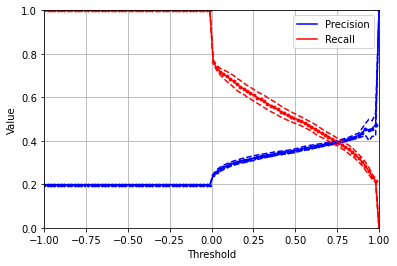

In [53]:
avg_type = 'macro'
precision_arr = np.load(save_dir / f'precision_trials_{n_trials}_{avg_type}_avg_arr.npy')
recall_arr = np.load(save_dir / f'recall_trials_{n_trials}_{avg_type}_avg_arr.npy')

precision_arr_avg = np.mean(precision_arr, axis=1)
precision_arr_se = np.std(precision_arr, axis=1, ddof=1)  # np.sqrt(np.std(precision_arr, axis=1, ddof=1)) / precision_arr.shape[1]
recall_arr_avg = np.mean(recall_arr, axis=1)
recall_arr_se = np.std(recall_arr, axis=1, ddof=1)  # np.sqrt(np.std(recall_arr, axis=1, ddof=1)) / recall_arr.shape[1]

f, ax = plt.subplots()
ax.scatter(thr_arr, precision_arr_avg, color='b', s=8)
ax.plot(thr_arr, precision_arr_avg, 'b', label='Precision')
ax.plot(thr_arr, precision_arr_avg + precision_arr_se, 'b--')
ax.plot(thr_arr, precision_arr_avg - precision_arr_se, 'b--')

ax.scatter(thr_arr, recall_arr_avg, color='r', s=8)
ax.plot(thr_arr, recall_arr_avg, 'r', label='Recall')
ax.plot(thr_arr, recall_arr_avg + recall_arr_se, 'r--')
ax.plot(thr_arr, recall_arr_avg - recall_arr_se, 'r--')

ax.set_xlabel('Threshold')
ax.set_ylabel('Value')
ax.grid()
ax.legend()
ax.set_xlim(thr_arr[[0, -1]])
# ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
# ax.set_xscale('log')
f.savefig(save_dir / f'precision_recall_{avg_type}_avg.pdf')

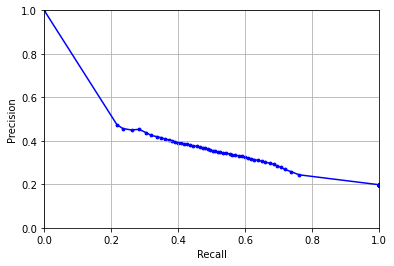

In [54]:
# plot PR curve

dataset = 'test'
f, ax = plt.subplots()
ax.scatter(recall_arr_avg, precision_arr_avg, color='b', s=8)
ax.plot(recall_arr_avg, precision_arr_avg, 'b')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.grid()
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim(right=1)
f.savefig(save_dir / f'pr_curve_{avg_type}_avg.pdf')

# Compute and plot precision and recall for no flags

In [55]:
thr_arr = np.linspace(-1, 1, 100, endpoint=True)
precision_arr, recall_arr = np.nan * np.zeros((len(thr_arr), n_trials), dtype='float'), np.nan * np.zeros((len(thr_arr), n_trials), dtype='float')

for trial_i in range(n_trials):

    dataset_scores = pd.read_csv(save_dir / f'exp_{n_pcs}_PCs_trial_{trial_i}' / f'{dataset}_scores.csv')
    dataset_scores = pd.merge(dataset_scores, robo_flags, on=['target_id', 'tce_plnt_num'], validate='one_to_one', how='left')

    # get columns with scores for each occlusion grouping
    scores_array = np.array(dataset_scores[score_cols])
    # get flags for each branch
    robo_noflag = np.array(dataset_scores[robo_cols[-1]])

    _ , branch_explanations_trials = post_process_flags(robo_array, scores_array, get_max=get_max, branch_idxs_to_keep=branch_idxs_to_keep[:-1])

    for thr_i, thr in enumerate(thr_arr):

        # add no_flag column; set to one when all other flags have non-positive explanation scores
        idxs_allfps_inactive = (branch_explanations_trials <= thr).all(axis=1)
        noflag_explanation = np.zeros((len(branch_explanations_trials), 1), dtype='float')
        noflag_explanation[idxs_allfps_inactive] = 1

        precision_arr[thr_i][trial_i] = precision_score(robo_noflag, noflag_explanation, zero_division=1)
        recall_arr[thr_i][trial_i] = recall_score(robo_noflag, noflag_explanation, zero_division=1)

precision_arr_avg = np.mean(precision_arr, axis=1)
recall_arr_avg = np.mean(recall_arr, axis=1)
np.save(save_dir / 'precision_arr_noflag.npy', precision_arr_avg)
np.save(save_dir / 'recall_arr_noflag.npy', recall_arr_avg)

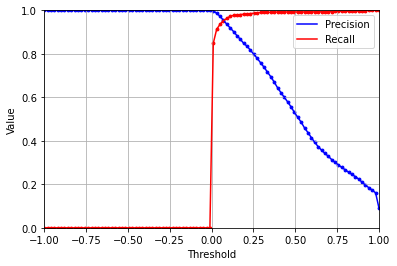

In [56]:
f, ax = plt.subplots()
ax.scatter(thr_arr, precision_arr_avg, color='b', s=8)
ax.plot(thr_arr, precision_arr_avg, 'b', label='Precision')
ax.scatter(thr_arr, recall_arr_avg, color='r', s=8)
ax.plot(thr_arr, recall_arr_avg, 'r', label='Recall')
ax.set_xlabel('Threshold')
ax.set_ylabel('Value')
ax.grid()
ax.legend()
ax.set_xlim(thr_arr[[0, -1]])
# ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
# ax.set_xscale('log')
# ax.set_yscale('log')
f.savefig(save_dir / f'precision_recall_thr_noneflag.pdf')

In [57]:
# compute precision and recall for no flag for a set of thresholds and save it to a csv file

thr_arr = np.linspace(-1, 1, 21, endpoint=True)
precision_arr, recall_arr = np.nan * np.zeros((len(thr_arr), n_trials), dtype='float'), np.nan * np.zeros((len(thr_arr), n_trials), dtype='float')
for trial_i in range(n_trials):

    dataset_scores = pd.read_csv(save_dir / f'exp_{n_pcs}_PCs_trial_{trial_i}' / f'{dataset}_scores.csv')
    dataset_scores = pd.merge(dataset_scores, robo_flags, on=['target_id', 'tce_plnt_num'], validate='one_to_one', how='left')

    # get columns with scores for each occlusion grouping
    scores_array = np.array(dataset_scores[score_cols])
    # get flags for each branch
    robo_noflag = np.array(dataset_scores[robo_cols[-1]])

    _ , branch_explanations_trials = post_process_flags(robo_array, scores_array, get_max=get_max, branch_idxs_to_keep=branch_idxs_to_keep[:-1])

    for thr_i, thr in enumerate(thr_arr):

        # add no_flag column; set to one when all other flags have non-positive explanation scores
        idxs_allfps_inactive = (branch_explanations_trials <= thr).all(axis=1)
        noflag_explanation = np.zeros((len(branch_explanations_trials), 1), dtype='float')
        noflag_explanation[idxs_allfps_inactive] = 1

        precision_arr[thr_i, trial_i] = precision_score(robo_noflag, noflag_explanation, zero_division=1)
        recall_arr[thr_i, trial_i] = recall_score(robo_noflag, noflag_explanation, zero_division=1)

data_df = pd.DataFrame({'thr': thr_arr, 'precision_mean': np.mean(precision_arr, axis=1), 'precision_std': np.std(precision_arr, axis=1, ddof=1), 'recall': np.mean(recall_arr, axis=1), 'recall_std': np.std(recall_arr, axis=1, ddof=1)})
data_df.to_csv(save_dir / 'precision_recall_noflag.csv', index=False)

# Plot histogram of scores for each flag

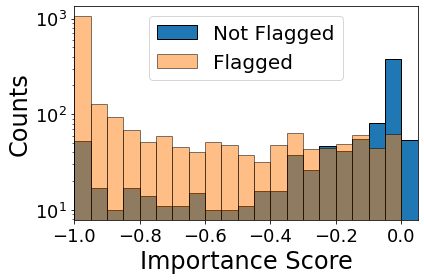

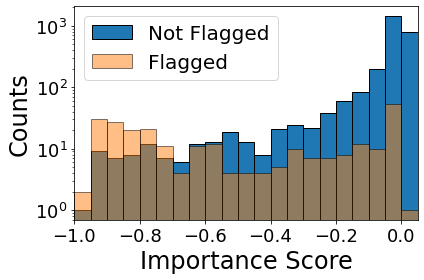

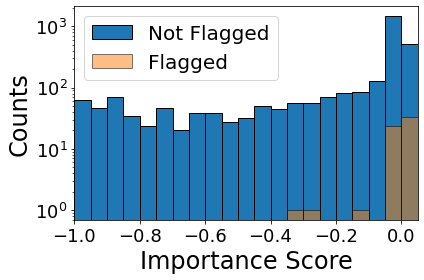

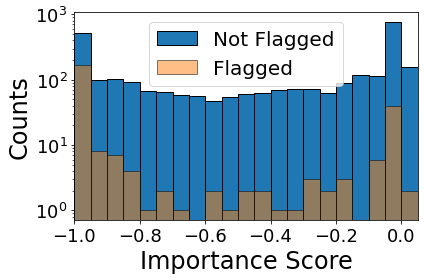

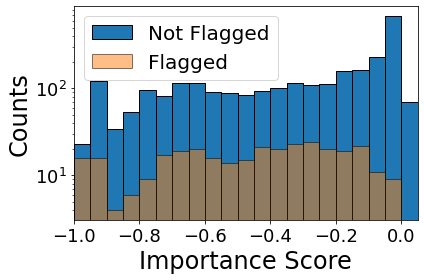

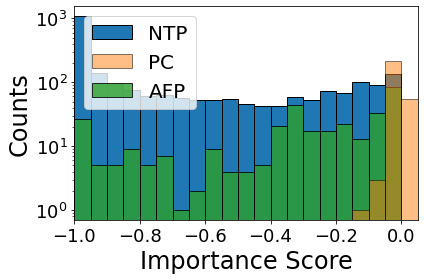

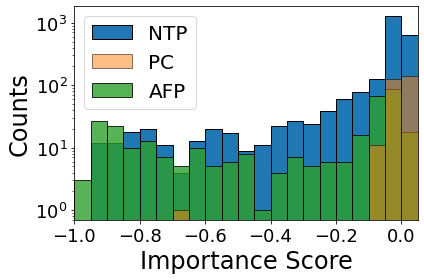

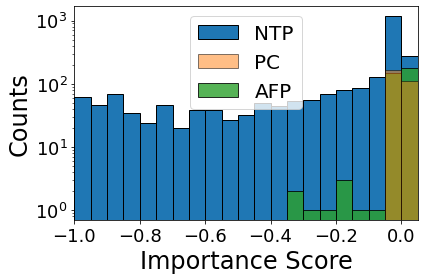

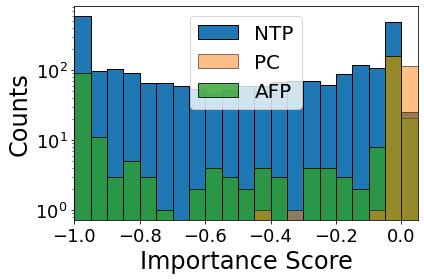

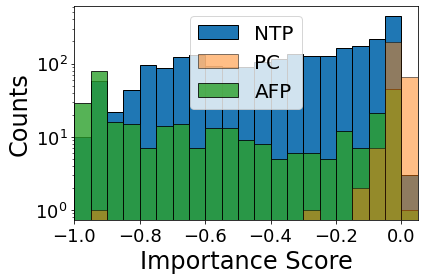

In [88]:
dataset = 'test'

# branch_explanations_trials_mean_tbl = pd.read_csv(save_dir / f'{dataset}_mean_scores.csv')
# branch_explanations_trials_mean_tbl = pd.merge(branch_explanations_trials_mean_tbl, robo_flags, on=['target_id', 'tce_plnt_num'], validate='one_to_one', how='left')

trial_i = 0
branch_explanations_trial_tbl = pd.read_csv(save_dir / f'exp_{n_pcs}_PCs_trial_{trial_i}' / f'{dataset}_scores.csv')
branch_explanations_trial_tbl = pd.merge(branch_explanations_trial_tbl, robo_flags, on=['target_id', 'tce_plnt_num'], validate='one_to_one', how='left')

# get columns with scores for each occlusion grouping

scores_array = np.array(branch_explanations_trial_tbl[score_cols])
# add no_flag column; set to one when all other flags have non-positive explanation scores
# scores_array[(scores_array <= 0)] = 0
# noflag_explanation = np.zeros((len(scores_array), 1), dtype='float')
# noflag_explanation[(scores_array == 0).all(axis=1)] = 1
# scores_array = np.concatenate([scores_array, noflag_explanation], axis=1)
# get flags for each branch
robo_array = np.array(branch_explanations_trial_tbl[robo_cols[:-1]])
robo, branch_explanations_trials_mean = post_process_flags(robo_array, scores_array, get_max=get_max, branch_idxs_to_keep=branch_idxs_to_keep[:-1])

branch_explanations_trials_mean = -1 * branch_explanations_trials_mean

# bins = np.linspace(-1, 0, 21, endpoint=True)
bins = np.arange(-1, 1, 0.05)
flags = ['Flux Flag', 'Centroid Flag', 'Odd Even Flag', 'Secondary Flag', 'DV Flag']  # , 'No Flag']

for flag_i, flag in enumerate(flags):

    examples_pos = branch_explanations_trials_mean[:, flag_i][robo[:, flag_i] == 1]
    examples_neg = branch_explanations_trials_mean[:, flag_i][robo[:, flag_i] == 0]
    # examples_pos = branch_explanations_trials_mean[:, flag_i][branch_explanations_trials_mean_tbl['original_label'] == 'PC']
    # examples_neg = branch_explanations_trials_mean[:, flag_i][branch_explanations_trials_mean_tbl['original_label'] == 'NTP']
    # examples_afp = branch_explanations_trials_mean[:, flag_i][branch_explanations_trials_mean_tbl['original_label'] == 'AFP']

    f, ax = plt.subplots()
    ax.hist(examples_neg, bins, edgecolor='k', zorder=0, label='Not Flagged')
    ax.hist(examples_pos, bins, edgecolor='k', zorder=1, label='Flagged', alpha=0.5)
    # ax.hist(examples_neg, bins, edgecolor='k', zorder=0, label='NTP')
    # ax.hist(examples_pos, bins, edgecolor='k', zorder=2, label='PC', alpha=0.5)
    # ax.hist(examples_afp, bins, edgecolor='k', zorder=1, label='AFP', alpha=0.8)
    # ax.set_xlabel('Mean Importance Score', fontsize=24)
    ax.set_xlabel('Importance Score', fontsize=24)
    ax.set_ylabel('Counts', fontsize=24)
    ax.legend(fontsize=20)
    ax.set_yscale('log')
    # ax.grid(axis='y')
    ax.tick_params(axis='both', which='major', labelsize=18)
    # ax.set_xlim([-0.02, 1])
    # ax.set_xlim(bins[[0, -1]])
    if flag == 'Centroid Flag':
        ax.set_xlim([-1, 0.05])
    elif flag == 'Odd Even Flag':
        ax.set_xlim([-1, 0.05])
    elif flag == 'Flux Flag':
        ax.set_xlim([-1, 0.05])
    elif flag == 'Secondary Flag':
        ax.set_xlim([-1, 0.05])
    elif flag == 'DV Flag':
        ax.set_xlim([-1, 0.05])
    else:
        ax.set_xlim([-1, 1])
    f.tight_layout()
    f.savefig(save_dir / f'hist_scores_labels_flag_{flag}_{dataset}_trial{trial_i}_norex.pdf')

for flag_i, flag in enumerate(flags):

    examples_pos = branch_explanations_trials_mean[:, flag_i][branch_explanations_trial_tbl['original_label'] == 'PC']
    examples_neg = branch_explanations_trials_mean[:, flag_i][branch_explanations_trial_tbl['original_label'] == 'NTP']
    examples_afp = branch_explanations_trials_mean[:, flag_i][branch_explanations_trial_tbl['original_label'] == 'AFP']

    f, ax = plt.subplots()
    ax.hist(examples_neg, bins, edgecolor='k', zorder=0, label='NTP')
    ax.hist(examples_pos, bins, edgecolor='k', zorder=2, label='PC', alpha=0.5)
    ax.hist(examples_afp, bins, edgecolor='k', zorder=1, label='AFP', alpha=0.8)
    # ax.set_xlabel('Mean Importance Score')
    ax.set_xlabel('Importance Score', fontsize=24)
    ax.set_ylabel('Counts', fontsize=24)
    ax.legend(fontsize=20)
    ax.set_yscale('log')
    # ax.grid()
    if flag == 'Centroid Flag':
        ax.set_xlim([-1, 0.05])
    elif flag == 'Odd Even Flag':
        ax.set_xlim([-1, 0.05])
    elif flag == 'Flux Flag':
        ax.set_xlim([-1, 0.05])
    elif flag == 'Secondary Flag':
        ax.set_xlim([-1, 0.05])
    elif flag == 'DV Flag':
        ax.set_xlim([-1, 0.05])
    else:
        ax.set_xlim([-1, 1])
    ax.tick_params(axis='both', which='major', labelsize=18)
    # ax.set_xlim([-0.02, 1])
    f.tight_layout()
    f.savefig(save_dir / f'hist_scores_labels_flag_{flag}_pcvsfp_{dataset}_trial{trial_i}_norex.pdf')

# Precision and recall threshold per flag

In [59]:
thr_arr = np.linspace(-1, 1, 100, endpoint=True)
precision_arr, recall_arr = np.nan * np.zeros((n_trials, robo.shape[1], len(thr_arr)), dtype='float'), np.nan * np.zeros((n_trials, robo.shape[1], len(thr_arr)), dtype='float')

for trial_i in range(n_trials):

    dataset_scores = pd.read_csv(save_dir / f'exp_{n_pcs}_PCs_trial_{trial_i}' / f'{dataset}_scores.csv')
    dataset_scores = pd.merge(dataset_scores, robo_flags, on=['target_id', 'tce_plnt_num'], validate='one_to_one', how='left')

    # get columns with scores for each occlusion grouping
    scores_array = np.array(dataset_scores[score_cols])
    # get flags for each branch
    robo_array = np.array(dataset_scores[robo_cols[:-1]])

    # scores_array = np.concatenate([scores_array, np.nan * np.zeros((len(scores_array), 1))], axis=1)
    robo, branch_explanations_trials = post_process_flags(robo_array, scores_array, get_max=get_max, branch_idxs_to_keep=branch_idxs_to_keep[:-1])
    # branch_explanations_trials = branch_explanations_trials[:, :-1]

    for thr_i, thr in enumerate(thr_arr):

            branch_explanations_thr = threshold(branch_explanations_trials, thr)  # 1 - threshold(branch_explanations_trials, thr)

            # # add no_flag column; set to one when all other flags have non-positive explanation scores
            # noflag_explanation = np.zeros((len(branch_explanations_thr), 1), dtype='float')
            # noflag_explanation[(branch_explanations_thr == 0).all(axis=1)] = 1
            # branch_explanations_thr = np.concatenate([branch_explanations_thr, noflag_explanation], axis=1)

            for flag_i in range(robo.shape[1]):
                precision_arr[trial_i, flag_i, thr_i] = precision_score(robo[:, flag_i], branch_explanations_thr[:, flag_i], zero_division=1)
                recall_arr[trial_i, flag_i, thr_i] = recall_score(robo[:, flag_i], branch_explanations_thr[:, flag_i], zero_division=1)

precision_arr_mean = np.mean(precision_arr, axis=0)
recall_arr_mean = np.mean(recall_arr, axis=0)

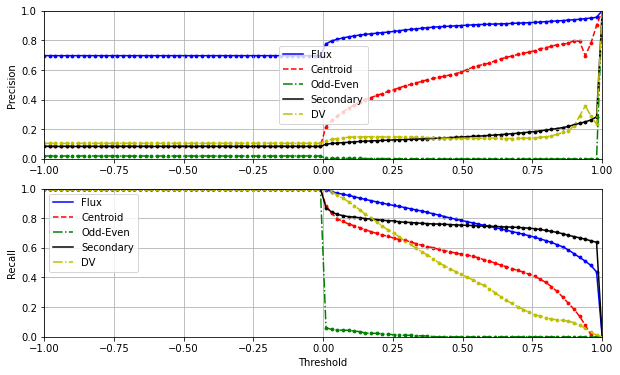

In [60]:
flag_plot_params = {
    'Flux': {'name': 'Flux', 'color': 'b', 'linestyle': '-'},
    'Centroid': {'name': 'Centroid', 'color': 'r', 'linestyle': '--'},
    'Odd-Even': {'name': 'Odd-Even', 'color': 'g', 'linestyle': '-.'},
    'Secondary': {'name': 'Secondary', 'color': 'k', 'linestyle': '-'},
    'DV': {'name': 'DV', 'color': 'y', 'linestyle': '-.'},
    # 'No Flag': {'name': 'No Flag', 'color': 'm', 'linestyle': '-.'},
}
f, ax = plt.subplots(2, 1, figsize=(10, 6))
for flag_i, flag in enumerate(flag_plot_params):
    ax[0].scatter(thr_arr, precision_arr_mean[flag_i, :], color=flag_plot_params[flag]['color'], s=8)
    ax[0].plot(thr_arr, precision_arr_mean[flag_i, :], label=flag_plot_params[flag]['name'], color=flag_plot_params[flag]['color'], linestyle=flag_plot_params[flag]['linestyle'])

    ax[1].scatter(thr_arr, recall_arr_mean[flag_i, :], color=flag_plot_params[flag]['color'], s=8)
    ax[1].plot(thr_arr, recall_arr_mean[flag_i, :], label=flag_plot_params[flag]['name'], color=flag_plot_params[flag]['color'], linestyle=flag_plot_params[flag]['linestyle'])

ax[0].set_ylabel('Precision')
ax[0].set_xlim(thr_arr[[0, -1]])
ax[0].set_ylim([0, 1])
ax[0].grid(True)
ax[0].legend()

ax[1].set_ylabel('Recall')
ax[1].set_xlim(thr_arr[[0, -1]])
ax[1].set_ylim([0, 1])
ax[1].grid(True)
ax[1].legend()
ax[1].set_xlabel('Threshold')

f.savefig(save_dir / 'precision_recall_thr_per_flag.pdf')